In [3]:
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit
from scipy.stats import mode

os.environ["CRDS_PATH"] = "/home/aqwork/miriroot/crds"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

# printing environment variables
print(os.environ['MIRISIM_ROOT'])
print(os.environ['PYSYN_CDBS'])
print(os.environ['CDP_DIR'])
print(os.environ['CRDS_PATH'])
print(os.environ['CRDS_SERVER_URL'])
print(os.environ['CRDS_CONTEXT'])

/home/aqwork/miriroot
/home/aqwork/miriroot/cdbs/
/home/aqwork/cdp
/home/aqwork/miriroot/crds
https://jwst-crds.stsci.edu
jwst_0641.pmap


In [4]:
# ip op paths and directories

mydir = os.getcwd()
mirisimopsource = '/20210830_144816_mirisim/det_images/'       # using output in /20210830_144816_mirisim , change mirisimopsource variable to switch folder
ipname = "det_image_seq1_MIRIMAGE_F1280Wexp1.fits"             # using "det_image_seq1_MIRIMAGE_F1280exp1.fits" input file, change ipname if other
mirisimopdir = mydir + mirisimopsource


# input file path

ippath = mirisimopdir + ipname
# print(ippath)

# output directory setup
my_output_dir = "pipeline_outputs/"
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)

2021-09-14 13:12:00,579 - stpipe - WARNING - /home/aqwork/miniconda3/lib/python3.9/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '




    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


In [6]:
# mask reference file exploration

# get pdq data
maskrefpath = '/home/aqwork/miriroot/crds/references/jwst/miri/jwst_miri_mask_0023.fits'
hdumask = fits.open(maskrefpath)
maskpdq = hdumask[1].data
hdumask.close()

# extract dnu pixels and plot
dnupix = np.where(np.bitwise_and(maskpdq,int(2**0)),1,0)
# fig,axs = plt.subplots(figsize = (10,10))
# axs.imshow(dnupix,origin='lower',cmap='Greys',interpolation='nearest')

# apply refmask and plot first frame
refmask = np.tile(dnupix,(1,40,1,1))
hdut = fits.open(ippath)
data = hdut[1].data
ndata = np.where(refmask == 1, np.nan, data)

In [7]:
# move source

import move_source_code as msc
import change_pixeldq as pixel

# import the step

from jwst.dq_init import dq_init_step

# print the description and options

print(dq_init_step.DQInitStep.__doc__)
print(dq_init_step.DQInitStep.spec)

# import the step
from jwst.jump import jump_step

# print the description and options
print(jump_step.JumpStep.__doc__)
print(jump_step.JumpStep.spec)

# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print(ramp_fit_step.RampFitStep.__doc__)
print(ramp_fit_step.RampFitStep.spec)

Initialize the Data Quality extension from the
    mask reference file.

    The dq_init step initializes the pixeldq attribute of the
    input datamodel using the MASK reference file.  For some
    FGS exp_types, initalize the dq attribute of the input model
    instead.  The dq attribute of the MASK model is bitwise OR'd
    with the pixeldq (or dq) attribute of the input model.
    

    output_ext         = string(default='.fits')     # Default type of output
    

    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR sigma rejection threshold
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
        flag_4_neighbors = boolean(default=True) # flag the four perpendicular neighbors of each CR
        max_jump_to_flag_neighbors = float(default=200) # maximum jump sigma that wi

In [8]:
# when using a different exposure, change ip

def runpip(use_existing_file,ip, mvx, pre = "pipeline_outputs"):
    
    msc_output_prefix = pre

    moverate = mvx # sets the rate of motion
    
    msc_op_dir = msc_output_prefix+'x'+str(moverate)+'/'        # op directory for msc
    msc_op_file = msc_op_dir+ipname[0:-5]+'_moved.fits'        # op file for msc
    
    
    # if path exists and using old file, then pull data
    if os.path.exists(msc_op_dir):
        if use_existing_file:
            try:
                print ('using existing file')
                dm_slopes =  datamodels.open(msc_op_dir+ipname[0:-5]+'_rate.fits')
                print('first output contains datamodel')

                print('second output contains path to\n')
                hdumoved = fits.open(msc_op_file)
                hdumoved.info()
                hdumoved.close()

                print('third output contains path to\n')
                opramp_path = msc_op_dir+ipname[0:-5]+'_ramp.fits'
                hduramp = fits.open(opramp_path)
                hduramp.info()
                hduramp.close()

                print('fourth output contains moverate: ',moverate)
                filled = 1
            except OSError as e:
                print(e)
                print('missing file(s), running custom pipeline')
                filled = 0
        else:
            print('ignoring existing files, running custom pipeline')
            filled = 0

    # if path does not exist then create new dir and if use existing is true then post message        
    if not os.path.exists(msc_op_dir):
        if use_existing_file:
            print('no existing file, running custom pipeline')
        os.mkdir(msc_op_dir)
        filled = 0
    
    if filled == 0:
        # generate refmask [1,40,1024,1032]
        refmask = np.tile(dnupix,(1,40,1,1))
        
        # run the msc code

        msc.move(ip, msc_op_file, refmask = refmask, velin = moverate)

        # use same input filename as above op file name

        dqi_op_file = msc_op_dir+ipname[0:-5]+'_moved_dqinitstep.fits'        # op file for msc

        # run the dqinit step

        dm_dqinit = dq_init_step.DQInitStep.call(msc_op_file, output_use_model=True, output_dir = msc_op_dir, save_results=True)

    #     print(dqi_op_file)

        cpdq_op_file = msc_op_dir+ipname        # op file for cpdq
        pixel.cpdq(dqi_op_file, cpdq_op_file)

    # remaining pipeline

        dm_slopes = Detector1Pipeline.call(cpdq_op_file, output_use_model=True, save_results=True, 
                                    output_dir=msc_op_dir, save_calibrated_ramp = True, steps={'dq_init': {'skip':True},'ipc': {'skip': True},
                                                                     'refpix': {'skip': True}, 'ramp_fit': {'save_opt': True}})

        opramp_path = msc_op_dir+ipname[0:-5]+'_ramp.fits'
    return(dm_slopes,msc_op_file,opramp_path,moverate)

In [9]:
wasteroid = 0.010996
t_1 = 2.775
hdu = fits.open(ippath)
frames = hdu[1].shape[1]
hdu.close()
pixelscale = 0.11
base = 416

In [10]:
def excol(mvrate, base = 416):
    extracols = np.ceil(wasteroid * mvrate * np.cos((np.pi)/4) * t_1 * frames / pixelscale)
    nancols = int(base + extracols)
    print('cols and shit :',extracols, nancols)
    return(nancols)

In [11]:
# apply masks
def maskandextract(ramps, gdq, mr, val = 2):
    cols = excol(mr)
    print('cols and shit :',cols,base)
    rows = cols - base
    mramps = ramps[:,:,5:-5,cols:-10]
    mgdq = gdq[:,:,5:-5,cols:-10]
    mcrramps = np.bitwise_and(mgdq,int(2**val))
    mcrramps = np.bitwise_and(mgdq,int(2**val))
    hduds9 = fits.open(ippath)
    hduds9[1].data = mcrramps
    hduds9.writeto("fords9x"+str(mr)+".fits", overwrite=True)
    hduds9.close()
    mcrhitscum = np.sum(mcrramps,axis = 1)[0]
    xdata = np.sum(mcrhitscum,axis = 0)
    ydata = np.sum(mcrhitscum,axis = 1)
    return(mcrramps,mramps,mgdq,mcrhitscum,xdata,ydata)

In [12]:
def plot3dgdq(data,cluster = 99,useaxes = (3,2,1), figdims =(10,10), fname = 'demo', az = -60, el = 30, at =  (0,0,0), xd = 0, setat = 0):
    # pass flag 99 to print multiple groups
    fig = plt.figure(figsize=figdims)
    ax = fig.add_subplot(1, 1, 1, projection='3d', azim = az, elev = el)
    if at == (0,0,0):
        at = (1,1.5,0.5)
    if cluster == 99:
        for cluster in np.unique(data):
            # if cluster is not nan, set
            if np.isnan(cluster) == 0:
                locs = np.where(data  == cluster)
                if cluster == -1:
                    plotlab = 'Noise'
                else:
                    plotlab = 'cluster '+str(int(cluster))
                ax.scatter(locs[useaxes[0]],locs[useaxes[1]],locs[useaxes[2]], label = plotlab,marker = 'o',alpha = 0.1)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_box_aspect(at)
        print ('99 aspect used is :', at)
        ax.zaxis.set_rotate_label(False)
        if az == -90:
            
            ax.set_xlabel('\n \nColumns\n \n', fontsize=14)
#             ax.set_ylabel('Rows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
            for line in ax.yaxis.get_ticklabels():
                line.set_visible(False)
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        elif az == 0:
            
#             ax.set_xlabel('Columns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('Frames\n \n', fontsize=14, rotation = 90)
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        else:
            ax.set_xlabel('\n \nColumns\n \n', fontsize=14)
            ax.set_ylabel('\n \nRows\n \n', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames\n \n', fontsize=14, rotation = 90)
#             for line in ax.yaxis.get_ticklines():
#                 line.set_visible(False)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
    else:
        locs = np.where(data == cluster)
#         print(locs)
        if setat:
            at = (max(locs[useaxes[0]]), max(locs[useaxes[1]]), 0.5*(max(max(locs[useaxes[0]]), max(locs[useaxes[1]]))))
        print ('aspect used is :', at)
        ax.set_box_aspect(at)
        ax.scatter(locs[useaxes[0]],locs[useaxes[1]],locs[useaxes[2]], label = 'cluster_'+str(cluster), c = 'red', marker = 'o',alpha = 0.1)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.zaxis.set_rotate_label(False)
        if az == -90:
            ax.set_xlabel('\n \nColumns', fontsize=14)
#             ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
            fig.tight_layout()
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        elif az == 0:
#             ax.set_xlabel('\n \nColumns', fontsize=14)
            ax.set_ylabel('\n \nRows', fontsize=14, rotation = 45)
            ax.set_zlabel('Frames\n \n', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
            for line in ax.xaxis.get_ticklabels():
                line.set_visible(False)
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
        else:
            ax.set_xlabel('\n \nColumns\n \n', fontsize=14)
            ax.set_ylabel('\n \nRows\n \n', fontsize=14, rotation = 45)
            ax.set_zlabel('\n \nFrames\n \n', fontsize=14, rotation = 90)
#             fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)
            fig.tight_layout()
#             for line in ax.xaxis.get_ticklines():
#                 line.set_visible(False)
            fig.savefig(fname+".png",format='png')
            fig.savefig(fname+".pdf",format='pdf')
            fig.show()
            
    plt.legend()
    return(fig,ax)

In [13]:
def buildsamples(crramp,eps = 5, plot = 0):
    print('unique values in the data are', np.unique(crramp))
    if plot == 1:
        plot3dgdq(crramp)
    mcrhitramps_shrink = np.where(crramp!=0)
    sampst = np.vstack((mcrhitramps_shrink[0],mcrhitramps_shrink[1],mcrhitramps_shrink[2],mcrhitramps_shrink[3]))
    sampsst = np.vstack((mcrhitramps_shrink[0],mcrhitramps_shrink[1]*(eps/2),mcrhitramps_shrink[2],mcrhitramps_shrink[3]))
    sampss = sampsst.T
    samps = sampst.T
    print('shape of samps array: ',samps.shape)
    print('shape of sampss array: ',sampss.shape)
    return(samps,sampss)

In [14]:
def cluster(crramps, unscaled_samples, scaled_samples, eps = 5, core = 180, grpno = 0,span = 0, vel = 0):
    db = DBSCAN(eps=eps, min_samples = core).fit(scaled_samples)
    
    labels = db.labels_
    clusters = np.unique(labels)
    clusters = clusters[clusters != -1]
    print(clusters)
    no_clusters = len(np.unique(labels))
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    print('Estimated no. of clusters: %d' % no_clusters,' with labels :', np.unique(labels))
    print('Estimated no. of noise points: %d' % no_noise)
    print('number of samples categorised: ',labels.shape)
    if span == 1:
        if vel == 30:
            ll = 9
        else:
            ll = 4
        for cname in clusters:
            locs = unscaled_samples[np.where(labels == cname)]
            print('range of frames for cluster',cname,':',min(locs[:,1]), max(locs[:,1]))
            if min(locs[:,1]) >= ll:
                print('cluster being dropped due to min frame criteria:', cname)
                labels = np.where(labels == cname, -1, labels)
            elif max(locs[:,1]) <= 34:
                print('cluster being dropped due to max frame criteria:', cname)
                labels = np.where(labels == cname, -1, labels)
            else:
                print('asteroid detected in cluster', cname)
    astclusters = np.unique(labels)
    if len(astclusters) == 1:
        print('no asteroid found')
        return(0,0,0)
    else:
        print('clusters representing asteroids :', astclusters[1:])
        lcls = []
        lsls = []
        for grp in astclusters:
            complabelledset,speclabelledset = lsets(crramps, unscaled_samples, scaled_samples, labels, grpno = grp)
            lcls.append(complabelledset)
            lsls.append(speclabelledset)
    return(lcls,lsls,astclusters)

In [15]:
def lsets(crramps, unscaled_samples, scaled_samples, labels, grpno = 0):
    complabelledset = np.copy(crramps).astype('float64')
    complabelledset = np.where(complabelledset == 0, np.nan, complabelledset)
    speclabelledset = np.copy(crramps).astype('float64')
    for num,val in enumerate(unscaled_samples):
#         print(val)
        complabelledset[val[0],val[1],val[2],val[3]] = labels[num]
    speclabels = np.where(labels == grpno,1,np.nan)
    for num,val in enumerate(unscaled_samples):
#         print(val)
        speclabelledset[val[0],val[1],val[2],val[3]] = speclabels[num]
    return(complabelledset,speclabelledset)

In [16]:
def curve(x,m,c):
    return((m*x)+c)

def fit2dline(func,f,x, iclust, loop = 'na:'):

    popt, pcov = curve_fit(curve, f,x)

    print(loop+' for cluster'+str(iclust)+' optimal slope multiplied by pixel scale and divided by frame time :', round(popt[0]*0.11/2.775,10))
    
    return (popt,pcov)

def fit2dlinecent(func,f,x, iclust, loop = 'na:', mean = 1):
    lx = []
    lf = []
    for fs in np.unique(f):
        xs = x[f==fs]
        if mean:
            xcentarr=np.mean(xs)
            lx.append(xcentarr)
        else:
            xcentarr=mode(xs)[0]
            lx.append(xcentarr[0])
        lf.append(fs)
        
#     for i,x in enumerate(lx):
#         if x == 272:
#             lx[i] = 268
            
#     print(lx,lf)
    
    popt, pcov = curve_fit(curve, lf,lx)

    print(loop+' for cluster'+str(iclust)+' optimal slope multiplied by pixel scale and divided by frame time :', round(popt[0]*0.11/2.775,10))
    
    return (popt,pcov,lx,lf)

In [20]:
def speedclustercombo(reuse = 1,vel = 5, clusternum = 99, ep = 5, core = 160, span = 0, fn = 'demo', pafname = 'demo',
                      az = -60, el = 30, printall = 0, flux = 0,colim = 99, cent = 1, mean = 1, setat = 0):
    if cent:    
        # MOVING
        (dm,moved,jumpdet,mvrate) = runpip(reuse,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract cr hits
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))


        ''' cluster the jumps find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core,
                                     span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el)
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[3]
    #             print(f.shape)
    #             print(x.shape)
                popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster, loop = 'in the first fit')
                v1 = round(popt[0]*0.11/2.775,10)
                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)

                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[2])[0]
                print('ploty is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
                    print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
                    print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,:,:,:],axis = 0)
                    ax[0].imshow(img,origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()

                    
                    
                    
                    
                    corepoints = np.where(difim >= co)
                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[3]
    #                 print(f.shape)
    #                 print(x.shape)
    
    
    
    
    
                    popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster,
                                                          loop = 'in the flux field', mean = mean)
                    v2 = round(popt[0]*0.11/2.775,10)
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)

                    for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.xaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_xticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[2])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                    ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        


                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', cluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                    
                    
                    
                    
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[3]
    #                         print(f.shape)
    #                         print(x.shape)
    
    
    
    

                            popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan', mean = mean)
                            v3 = round(popt[0]*0.11/2.775,10)
    #                         
#                             popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(clsrs[-1], useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)

                            for line in ax.yaxis.get_ticklabels():
                                line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.xaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_xticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[2])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                            ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
                            
                            
                            
                            
                            
    else:
        # MOVING
        (dm,moved,jumpdet,mvrate) = runpip(reuse,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract cr hits
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))


        ''' cluster the jumps find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core, span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el, at = (0,0,0))
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[3]
                print(f.shape)
                print(x.shape)
                popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the first fit')
                v1 = round(popt[0]*0.11/2.775,10)
                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)
                ax.annotate('Extracted x-component of velocity = '+str(v1), xy=(0.0, 0.95), xycoords='axes fraction',
                                         fontsize=12, color='k')
                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[2])[0]
                print('ploty is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                 ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
#                     print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
#                     print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,1:,:,:],axis = 0)
                    ax[0].imshow(asteroid[0,-1,:,:],origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()

                    
                    
                    
                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[3]
#                     print(f.shape)
#                     print(x.shape)




                    popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the flux field')
                    v2 = round(popt[0]*0.11/2.775,10)
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)
                    ax.annotate('Extracted x-component of velocity = '+str(v2), xy=(0.0, 0.95), xycoords='axes fraction',
                                         fontsize=12, color='k')
                    for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.xaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_xticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[2])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                     ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        


                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', cluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                    
                    
                    
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[3]
    #                         print(f.shape)
    #                         print(x.shape)

    
    
    
                            popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan')
                            v3 = round(popt[0]*0.11/2.775,10)
    #                         popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(clsrs[-1], useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)
                            ax.annotate('Extracted x-component of velocity = '+str(v3), xy=(0.0, 0.95), xycoords='axes fraction',
                                         fontsize=12, color='k')
                            for line in ax.yaxis.get_ticklabels():
                                line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.xaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_xticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[2])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
#                             ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
    return(mramp,v1,v2,v3)

In [26]:
# same as above cell but now for the y coordinate


def speedclustercomboy(reuse = 1,vel = 5, clusternum = 99, ep = 5, core = 160, span = 0, fn = 'demo', pafname = 'demo',
                      az = -60, el = 30, printall = 0, flux = 0,colim = 99, cent = 1, mean = 1, setat = 0):
    if cent:    
        # MOVING
        (dm,moved,jumpdet,mvrate) = runpip(reuse,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract cr hits
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))


        ''' cluster the jumps find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core,
                                     span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el)
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[2]
    #             print(f.shape)
    #             print(x.shape)
                popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster, loop = 'in the first fit')
                v1 = round(popt[0]*0.11/2.775,10)
                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)

                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[2])[0]
                print('ploty is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
                    print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
                    print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,:,:,:],axis = 0)
                    ax[0].imshow(img,origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()

                    
                    
                    
                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[2]
    #                 print(f.shape)
    #                 print(x.shape)
    
    
    
    
    
                    popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = icluster,
                                                          loop = 'in the flux field', mean = mean)
                    v2 = round(popt[0]*0.11/2.775,10)
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)

                    for line in ax.yaxis.get_ticklabels():
                        line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.xaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_xticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[2])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                    ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        


                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', cluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                    
                    
                    
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[2]
    #                         print(f.shape)
    #                         print(x.shape)
    
    
    

                            popt,pcov,xlist,flist = fit2dlinecent(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan', mean = mean)
                            v3 = round(popt[0]*0.11/2.775,10)
    #                         
#                             popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(clsrs[-1], useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)

#                             for line in ax.yaxis.get_ticklabels():
#                                 line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.xaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(xdown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_xticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[2])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = xs,ys = ys,zs = zs, label = 'curve_fit result')
                            ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
                            
                            
                            
                            
                            
    else:
        # MOVING
        (dm,moved,jumpdet,mvrate) = runpip(reuse,ippath, vel) # return(dm_slopes,msc_op_file,opramp_path,moverate
    #     print(mvrate)
        hduramp = fits.open(jumpdet)
        ramp = hduramp[1].data
        gdq = hduramp[3].data
        hduramp.close()

        # mask data and extract cr hits
        mcrhitramps,mramp,mgdq,mcrhitscum,xdata,ydata  = maskandextract(ramp, gdq, mr = mvrate)
    #     hduramp = fits.open(mramp)
    #     mramp = hduramp[1].data
    #     hduramp.close()

        if printall == 1:
            plot3dgdq(mgdq,cluster = 4, fname = pafname+'0', az = az, el = el)
            fig,ax = plt.subplots(1,1, figsize = (10,10))
            print(mramp.shape)
            ax.imshow(mramp[0,-1,:,:], origin = 'lower', cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))
            fig.show()

        ''' cluster the jumps find asteroids and plot detections '''

        samps,sampss = buildsamples(mcrhitramps)
    #     print(cluster)
        cls, sls, clusters = cluster(mcrhitramps, samps, sampss, eps = ep , core = core, span = span, vel = vel)
        if (cls, sls, clusters) == (0,0,0):
            print('premature exit')
        else:
            plot3dgdq(cls[-1],cluster = clusternum, fname = fn+'1', az = az, el = el, at = (0,0,0))
            clusters = clusters[clusters != -1]

            ''' for each cluster with an asteroid, plot cluster, extract fluxes and plot fluxes '''        

            for icluster in clusters:
                print('checking cluster : ', icluster)
                scatpoints = np.where(cls[-1] == icluster)
                f = scatpoints[1]
                x = scatpoints[2]
    #             print(f.shape)
    #             print(x.shape)
                popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the first fit')
                v1 = round(popt[0]*0.11/2.775,10)
                (fig,ax) = plot3dgdq(cls[-1], cluster = icluster, fname = fn+'2', az = az, el = el, at = (0,0,0), setat = setat)

                zs = np.linspace(0,39,40)
                xs = curve(zs,popt[0],popt[1])
                yrange = np.where(cls[-1] == icluster)
                ploty = mode(yrange[3])[0]
                print('plotx is ',ploty)
                ys = np.full_like(xs,ploty)

    #             print(zs.shape,xs.shape,ys.shape)
                ax.plot(xs = ys,ys = xs,zs = zs, label = 'curve_fit result',c = 'orange')
                ax.annotate('Extracted y-component of velocity = '+str(v1), xy=(0.0, 0.95), xycoords='axes fraction',
                             fontsize=12, color='k')
#                 ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                plt.legend()
                plt.show()
                fig.savefig(fn+'2'+".png",format='png')
                fig.savefig(fn+'2'+".pdf",format='pdf')

                if flux:
                    ymax = max(scatpoints[2])
                    ymin = min(scatpoints[2])
                    xmax = max(scatpoints[3])
                    xmin = min(scatpoints[3])

                    yup = ymax + 10
                    ydown = max(0,ymin - 10)
                    xup = xmax + 10
                    xdown = max(0,xmin - 10)

                    print(yup,ydown,xup,xdown)

                    asteroid = mramp[:,:,ydown:yup,xdown:xup]
                    print(asteroid.shape)
                    difim = np.diff(asteroid, axis = 1)[:,1:,:,:]
                    print(difim.shape)
                    fig,ax = plt.subplots(1,2,figsize = (10,10))
                    img = np.mean(difim[0,1:,:,:],axis = 0)
                    ax[0].imshow(img,origin = 'lower')
                    co = np.percentile(difim.flatten(),colim)
                    print('flux cutoff used for defining asteroid core = ',co)
                    h1 = plt.hist(difim.flatten(), bins = 100, histtype = 'step', log = True)
                    ax[1].set_title("flux distrubution")
                    ax[1].set_ylabel("count of pixels")
                    ax[1].set_xlabel("counts / DN")
                    plt.show()
                    
                    
                    

                    if icluster == 0:
                        icluster = 999
                        print('changed cluster number to 999 for ease of application')
                    a = np.where(difim >= co,icluster,0)
                    f = np.where(a == icluster)[1]
                    x = np.where(a == icluster)[2]
    #                 print(f.shape)
    #                 print(x.shape)
    
    
    
                    popt,pcov = fit2dline(curve,f,x, iclust = icluster, loop = 'in the flux field')
                    v2 = round(popt[0]*0.11/2.775,10)
                    (fig,ax) = plot3dgdq(a, useaxes = (3,2,1), cluster = icluster, fname = fn+'3',
                                         az = az, el = el, at = (0,0,0), setat = setat)
                    ax.annotate('Extracted y-component of velocity = '+str(v2), xy=(0.0, 0.95), xycoords='axes fraction',
                             fontsize=12, color='k')
#                     for line in ax.yaxis.get_ticklabels():
#                         line.set_visible(False)
                    axlabs = []
    #                 print(ax.xaxis.get_ticklabels())
                    for line in ax.yaxis.get_ticklabels():
                        txt =  line.get_text()
#                         print(ord(txt[0]),xdown)
    #                     print('converting and adding: ',txt)
                        txt = str(float(ydown)+float(txt.replace('\u2212', '-')))
                        axlabs.append(txt)
                    ax.set_yticklabels(axlabs)

    #                 line.set_visible(False)

                    zs = np.linspace(-4,43,48)
                    xs = curve(zs,popt[0],popt[1])
                    yrange = np.where(a == icluster)
                    ploty = mode(yrange[3])[0]
                    ys = np.full_like(xs,ploty)

    #                 print(zs.shape,xs.shape,ys.shape)
                    ax.plot(xs = ys,ys = xs,zs = zs, label = 'curve_fit result', c = 'orange')
#                     ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                    plt.legend()
                    plt.show()
                    fig.savefig(fn+'3'+".png",format='png')
                    fig.savefig(fn+'3'+".pdf",format='pdf')



                    ''' cluster the fluxes and plot, if more than one cluster detected again, renege '''        


                    sampsrs,sampssrs = buildsamples(a)
                    print('checking cluster : ', cluster)
                    clsrs, slsrs, clustersrs = cluster(a, sampsrs, sampssrs, eps = 3, core = 20, span = 1, vel = vel)
                    if (clsrs, slsrs, clustersrs) == (0,0,0):
                        print('premature exit in the cluster loop for cluster ',icluster)
                    else:
                        clustersrs = clustersrs [clustersrs != -1]
                        if len(clustersrs) > 1:
                            print('still more than one cluster, abandoning')
            #             print(len(cls))
                        else:
                    
                    
                    
                            if clustersrs[0] == 0:
                                clustersrs[0] = 999
                                clsrs[-1] = np.where(clsrs[-1] == 0,999,clsrs[-1])
                                print('changed cluster number to 1 for ease of application')
                            scatpoints = np.where(clsrs[-1] == clustersrs[0],clustersrs[0],0)
                            f = np.where(scatpoints == clustersrs[0])[1]
                            x = np.where(scatpoints == clustersrs[0])[2]
    #                         print(f.shape)
    #                         print(x.shape)
    
    
    

                            popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0],
                                                                  loop = 'in the flux field after another dbscan')
                            v3 = round(popt[0]*0.11/2.775,10)
    #                         popt,pcov = fit2dline(curve,f,x, iclust = clustersrs[0], loop = 'in the flux field after another dbscan')
    #                         plot3dgdq(cls[-1], cluster = clusters[0], fname = fn, az = az, el = el)

                            (fig,ax) = plot3dgdq(clsrs[-1], useaxes = (3,2,1), cluster = clustersrs[0],
                                                 fname = fn+'4', az = az, el = el, at = (0,0,0), setat = setat)
                            ax.annotate('Extracted y-component of velocity = '+str(v3), xy=(0.0, 0.95), xycoords='axes fraction',
                                         fontsize=12, color='k')
#                             for line in ax.yaxis.get_ticklabels():
#                                 line.set_visible(False)
    #                             print(ax.xaxis.get_ticklabels())
                            axlabs = []
                            for line in ax.yaxis.get_ticklabels():
                                txt =  line.get_text()
    #                             print('converting and adding: ',txt)
                                txt = str(float(ydown)+float(txt.replace('\u2212', '-')))
    #                             txt = str(xdown+int(txt))
                                axlabs.append(txt)
                            ax.set_yticklabels(axlabs)

                            zs = np.linspace(0,39,40)
                            xs = curve(zs,popt[0],popt[1])
                            yrange = np.where(clsrs[-1] == clustersrs[0])
                            ploty = mode(yrange[3])[0]
                            ys = np.full_like(xs,ploty)

            #                 print(zs.shape,xs.shape,ys.shape)
                            ax.plot(xs = ys,ys = xs,zs = zs, label = 'curve_fit result', c = 'orange')
#                             ax.scatter(xlist,np.full_like(xlist,ploty),flist, label = 'centroids')
                            plt.legend()
                            plt.show()
                            fig.savefig(fn+'4'+".png",format='png')
                            fig.savefig(fn+'4'+".pdf",format='pdf')
    return(mramp,v1,v2,v3)

# run all cells upto this point before proceeding below

### basic fit : if you run a cell for a new velocity, it will produce a new output file from runpip and might take a little time to run

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

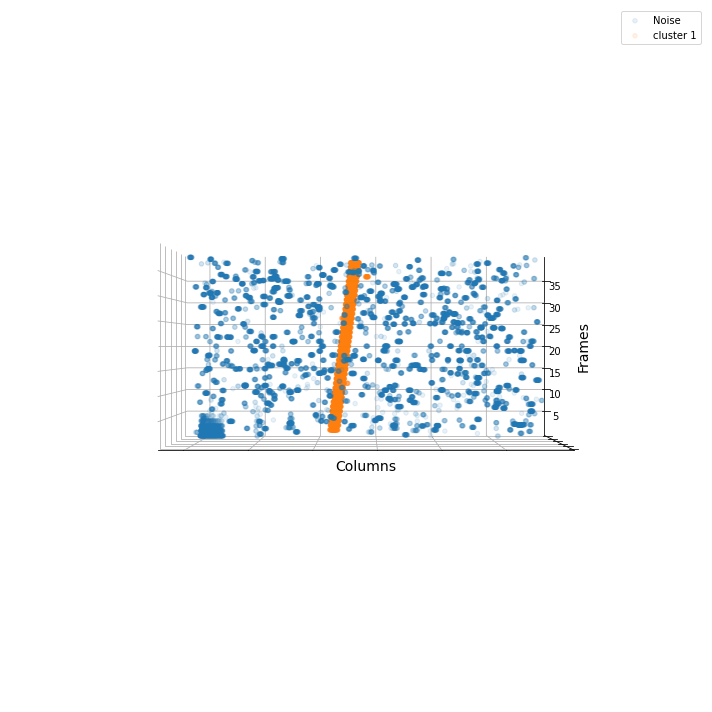

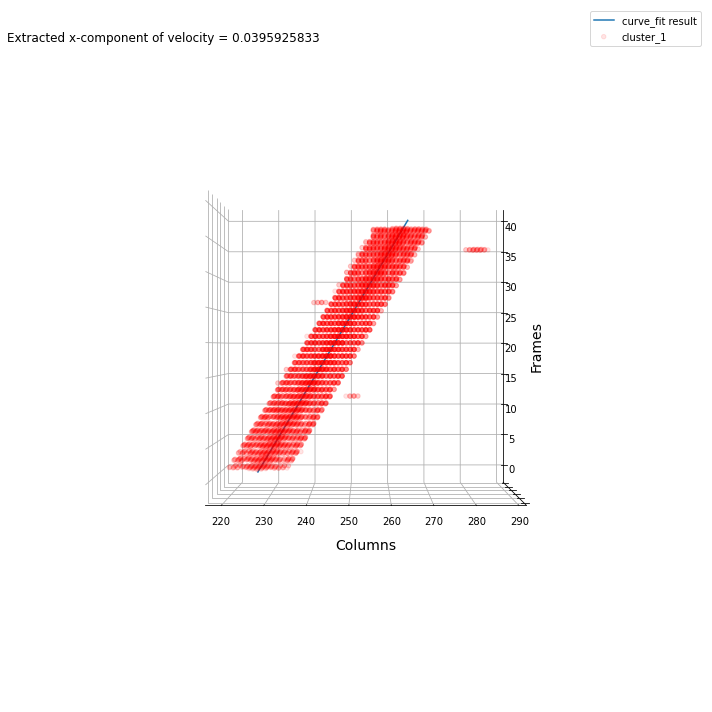

579 508 297 211
flux cutoff used for defining asteroid core =  78.32105468749995


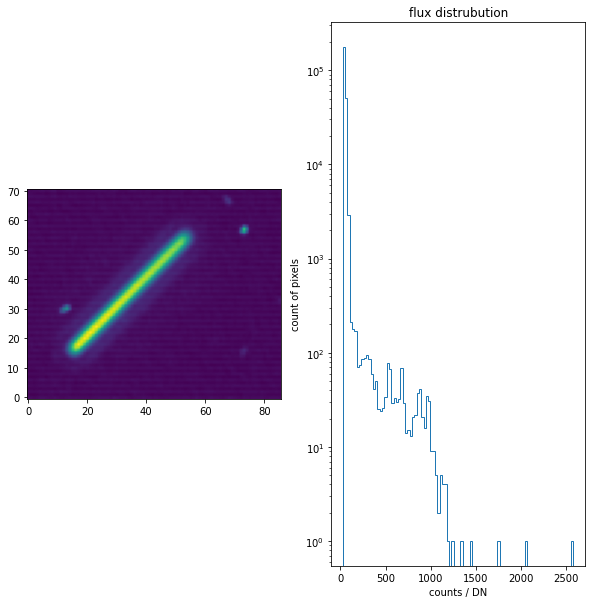

in the flux field for cluster1 optimal slope multiplied by pixel scale and divided by frame time : 0.03836569
aspect used is : (85, 69, 42.5)


2021-09-14 13:26:44,206 - stpipe - WARNING - <ipython-input-20-ea8839159c03>:338: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



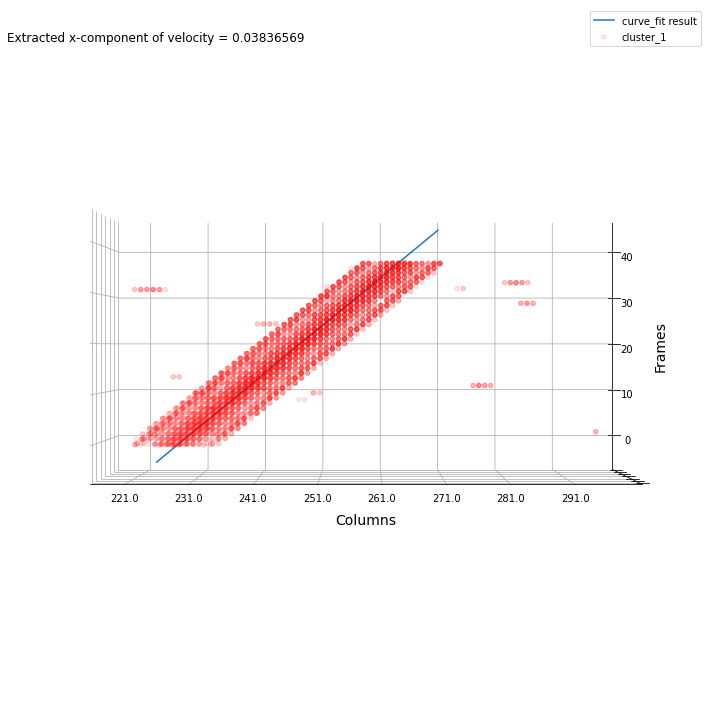

unique values in the data are [0 1]
shape of samps array:  (4641, 4)
shape of sampss array:  (4641, 4)
checking cluster :  <function cluster at 0x7fd9995f7310>
[0 1]
Estimated no. of clusters: 3  with labels : [-1  0  1]
Estimated no. of noise points: 90
number of samples categorised:  (4641,)
range of frames for cluster 0 : 0 37
asteroid detected in cluster 0
range of frames for cluster 1 : 31 31
cluster being dropped due to min frame criteria: 1
clusters representing asteroids : [0]
changed cluster number to 1 for ease of application
in the flux field after another dbscan for cluster999 optimal slope multiplied by pixel scale and divided by frame time : 0.0389459297
aspect used is : (60, 61, 30.5)


2021-09-14 13:26:45,503 - stpipe - WARNING - <ipython-input-20-ea8839159c03>:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axlabs)



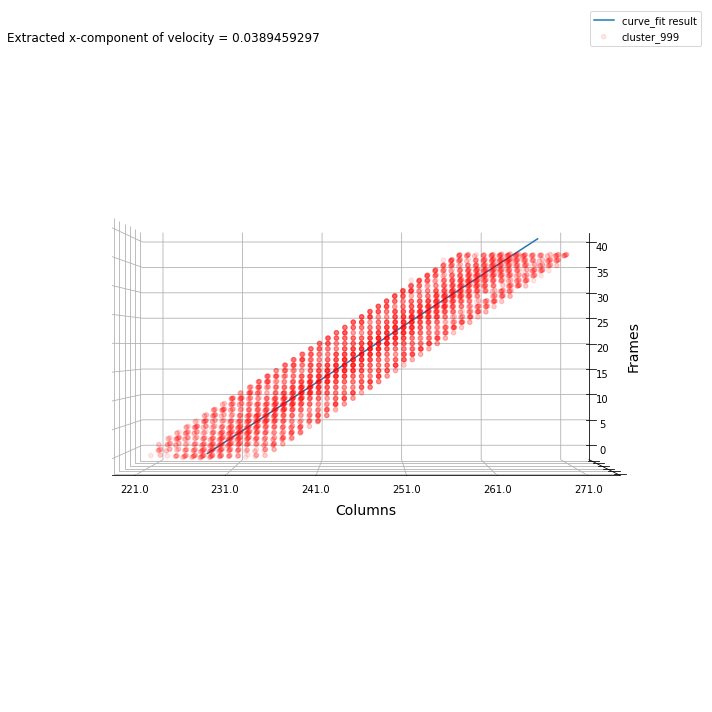

In [28]:
dumx,x1,x2,x3 = speedclustercombo(reuse = 1, vel = 5, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanxd1f1v5', az = -90, el = 0,
                  flux = 1, colim = 98, cent = 0, mean = 1, setat = 1)

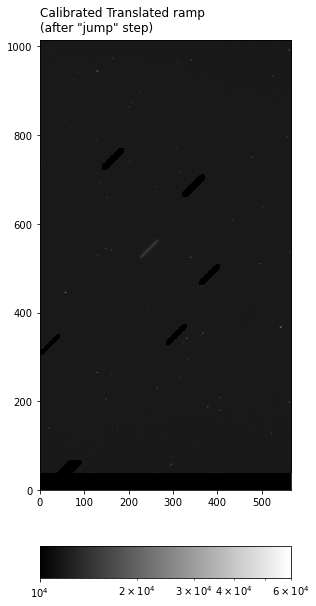

In [23]:
# import matplotlib.gridspec as gridspec
# fig = plt.figure(figsize = (10,5))
# G = gridspec.GridSpec(2,2, height_ratios = [10,0.5], width_ratios = [2.5,5])
# ax1 = plt.subplot(G[0,0])
# ax3 = plt.subplot(G[1,0])
# ax2 = plt.subplot(G[:,1], projection = '3d', azim = -80, elev = 10)
fig,ax = plt.subplots(2,1, figsize = (4.5,10), gridspec_kw = {'height_ratios':[10,0.7]})
ax[0].set_facecolor('black')
a1 = ax[0].imshow(dumx[0,-1,:,:], origin = 'lower',cmap = 'gist_gray', norm = LogNorm(vmin = 1e4, vmax = 6e4))
plt.colorbar(a1, cax=ax[1], orientation='horizontal')
ax[0].annotate('Calibrated Translated ramp\n(after \"jump\" step)', xy=(0.0, 1.02), xycoords='axes fraction',
               fontsize=12, color='k')
# ax2 = plt.subplot(G[:,1], projection = '3d', azim = -80, elev = 10)
plt.show()
fig.savefig("2dsim.png",format='png')
fig.savefig("2dsim.pdf",format='pdf')


In [ ]:
dumy,y1,y2,y3 = speedclustercomboy(reuse = 1, vel = 5, clusternum = 99, ep = 17, core = 50, span = 1, fn = 'dbscanyd1f1v5', az = 0, el = 0,
                  flux = 1, colim = 98, cent = 0, mean = 1, setat = 1)

using existing file
first output contains datamodel
second output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_moved.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     117   ()      
  1  SCI           1 ImageHDU        50   (1032, 1024, 40, 1)   float64   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (258, 1024, 40, 1)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5874B]   
third output contains path to

Filename: pipeline_outputsx5/det_image_seq1_MIRIMAGE_F1280Wexp1_ramp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 ImageHDU        47   (1032, 1024, 40, 1)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 

In [ ]:
# calculation of velocity using the first and third estimates from both components

print(((x1**2)+(y1**2))**0.5)
print(((x3**2)+(y3**2))**0.5)